In [45]:
#//----------------------------
#//LIBRARIES
    #Math
import math
    #Numeric Python
import numpy as np
    #Pandas (dataframes)
import pandas as pd
    #datetime for fate manipulation
from datetime import date, datetime, timedelta  
    #Regex for advanced string matching
import re
    #for time related stuff
import time
    #json library
import json
    #Analyst tools
import sys
sys.path.append('../')
from analysts_tools.growth import *
    #Procurement tools
from procurement_lib import send_slack_notification
from procurement_lib import redash
from analysts_tools.redash_methods import *

import random
import time
import datetime

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

In [46]:
frida_products = get_fresh_query_result("https://internal-redash.federate.frubana.com/",118629,'SeoGHWmDUaaBi7VXje1s9zYNiMD1VHQ1K1DYOxiF',{},20)

200


In [47]:
frida_products

,ciudad::multiFilter,id_tarjeta,categoria,subcategoria,card_name,skus
0,BAQ,131815,Abarrotes,Aceites & Grasas,Aceite de oliva extra virgen 1LT,162752
1,BAQ,131814,Abarrotes,Aceites & Grasas,Aceite de oliva extra virgen 500ml,162750
2,BAQ,257059,Abarrotes,Aceites & Grasas,Aceite de Oliva Virgen Extra de 3000ml,333339
3,BAQ,180605,Abarrotes,Aceites & Grasas,Aceite Naoli 20LT,222598
4,BAQ,180812,Abarrotes,Aceites & Grasas,Aceite Naoli 3LT,222614
...,...,...,...,...,...,...
7138,VCP,356518,Mercearia,Temperos,Orégano Kitano 200g,481216
7139,VCP,356519,Mercearia,Temperos,Pimenta Preta em Pó Kitano 50g,481219
7140,VCP,325938,Mercearia,Temperos,Sal Lebre 1Kg,430833
7141,VCP,325937,Mercearia,Temperos,Sal Miramar 1Kg,430830


In [48]:
query = """
select distinct
    site.identifier_value as region_code,
    --cp.category,
    --competitor.competitor_name,
    --comp_type.source_code as type,
    --quot_date.full_date as quotation_date,
    EXTRACT(WEEK FROM created_at.full_date) as week,
    su.card_id,
    su.description,
    --source_type.source_code as source,
    --cp.median_price,
    --cp.number_product_day_quotes,
    --cp.outlier,
    --ot.description as outlier_type,
    --cp.coutn_prices,
    AVG(cp.price)
    --cp.purchase_last_price,
    --cp.stdev_price
from dpr_pricing.snap_daily_collected_prices cp
    left join dpr_shared.dim_site site
        on cp.dim_site = site.site_id
    left join dpr_pricing.dim_competitor competitor
        on cp.dim_competitor = competitor.competitor_id
    left join dpr_pricing.dim_competitor_type comp_type
        on cp.dim_competitor_type = comp_type.competitor_type_id
    left join dpr_pricing.dim_source_type source_type
        on cp.dim_source_type = source_type.source_type_id
    left join dpr_shared.dim_date quot_date
        on cp.dim_quotation_date = quot_date.date_id
    left join dpr_pricing.dim_outlier_type ot
        on cp.dim_outlier_type = ot.outlier_type_id
    left join dpr_shared.dim_date created_at
        on cp.dim_upload_date = created_at.date_id
    left join dpr_shared.dim_stock_unit su
        on cp.dim_stock_unit = su.stock_unit_id
where created_at.full_date > '2021-12-31'
    and created_at.full_date < '2023-01-01'
    and comp_type.source_code  = 'main_competitor'
    and site.identifier_value NOT IN ('PBC','GDL')
    and su.product_id != 0
    and su.source_parent_id = 0
    and cp.price > 1
    and cp.outlier = false
GROUP BY 1,2,3,4
"""

data_ventas_aux_2 = read_connection_data_warehouse.run_read_dwd_query(query)
#data_ventas_aux_2["created_at"] = pd.to_datetime(data_ventas_aux_2["created_at"])

In [49]:
query = """
-- 93058
-- Se toma como base el query 2718
WITH 
ful AS (

SELECT DISTINCT
    bo.order_id,
    bo.submit_date
    
FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_fulfillment_group" bfg        ON bfg.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_fulfillment_order" bfo        ON bfo.fulfillment_group_id = bfg.fulfillment_group_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_fulfillment_group" ffg         ON ffg.fulfillment_group_id = bfg.fulfillment_group_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order" fo                      ON fo.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_payment" bop            ON bop.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site" s                       ON s.site_id = bo.site_disc
LEFT JOIN  postgres_broadleaf_federate."broadleaf.fb_order_type" fot                ON fot.fb_order_type_id=fo.fb_order_type_id
LEFT JOIN  postgres_broadleaf_federate."broadleaf.blc_order_adjustment" ba          ON ba.order_id = bo.order_id

WHERE fo.fb_order_status_id IN (1,6,7,8)
    AND extract(year from bo.submit_date::date) = 2022
    AND bo.order_status = 'SUBMITTED'
    AND bfo.status NOT IN ('ARCHIVED','CANCELLED')
    AND bop.archived = 'N'
    AND (fot.name IS NULL OR fot.name <> 'REFUND')
    
GROUP BY bo.order_id, bo.submit_date
),

more AS (
SELECT DISTINCT
    s.site_identifier_value AS city,
    bs.addl_product_id AS padre_sku_id,
    DATE(bo.submit_date) AS submit_date,
    AVG(boi.sale_price+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS final_price,    
    AVG(boida.adjustment_value) AS dct_value,
    AVG(boi.sale_price-boida.adjustment_value+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS net_final_price,
    SUM(boi.quantity*foi.step_unit) AS cant

FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site"                     s       ON s.site_id = bo.site_disc
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_item"               boi     ON boi.order_id=bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order_item"                foi     ON boi.order_item_id= foi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order"                     fo      ON fo.order_id = bo.order_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_price_dtl"     boipd   ON boipd.order_item_id=boi.order_item_id
INNER JOIN ful                                                                          ON ful.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_discrete_order_item"      bdoi    ON bdoi.order_item_id = boi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs      ON bs.sku_id = bdoi.sku_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_product"                  bp      ON bs.addl_product_id = bp.product_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs2     ON bs2.sku_id = bp.default_sku_id --Conectar la tarjeta con el sku que guarda la info
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat    ON bcat.category_id = bp.default_category_id 
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category_xref"            bcx     ON bcx.sub_category_id = bp.default_category_id AND bcx.archived='N' AND bcx.sndbx_tier is NULL
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat2   ON bcx.category_id = bcat2.category_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_dtl_adj"       boida   ON boida.order_item_price_dtl_id=boipd.order_item_price_dtl_id

WHERE fb_order_status_id IN (1,6,7,8)
    AND bo.order_status = 'SUBMITTED'
   -- FIX SUPER DESCUENTOS
    AND bcat2.category_id not in ('110873','-1000','100768','100765','100815') --ids de super descuentos en cada país
    AND bcat.name <> 'Oferton Frubana' AND bcat2.name <> 'Oferton Frubana'
    AND (boida.offer_name ILIKE '%hoo%' OR boida.offer_name ILIKE '%investment%' OR boida.offer_name ILIKE '%merm%' OR boida.offer_name ILIKE '%acmk%' OR boida.offer_name ILIKE '%mktpl%')
    AND boi.quantity > 0
    AND foi.step_unit > 0
    
GROUP BY 1,2,3
),

aall AS (

SELECT DISTINCT
    s.site_identifier_value AS city,
    bs2.name,
    bs.addl_product_id AS padre_sku_id,
    bcat2.name AS cat,
    bcat.name AS subcat,
    DATE(bo.submit_date) AS submit_date,
    AVG(boi.sale_price+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS final_price,    
    0 AS dct_value,
    AVG(boi.sale_price-0+(foi.total_tax_iva/(boi.quantity*foi.step_unit))) AS net_final_price,
    SUM(boi.quantity*foi.step_unit) AS cant
    
FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site"                     s       ON s.site_id = bo.site_disc
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_item"               boi     ON boi.order_id=bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order_item"                foi     ON boi.order_item_id= foi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order"                     fo      ON fo.order_id = bo.order_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_price_dtl"     boipd   ON boipd.order_item_id=boi.order_item_id
INNER JOIN ful                                                                          ON ful.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_discrete_order_item"      bdoi    ON bdoi.order_item_id = boi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs      ON bs.sku_id = bdoi.sku_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_product"                  bp      ON bs.addl_product_id = bp.product_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs2     ON bs2.sku_id = bp.default_sku_id --Conectar la tarjeta con el sku que guarda la info
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat    ON bcat.category_id = bp.default_category_id 
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category_xref"            bcx     ON bcx.sub_category_id = bp.default_category_id AND bcx.archived='N' AND bcx.sndbx_tier is NULL
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat2   ON bcx.category_id = bcat2.category_id
LEFT JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_dtl_adj"       boida   ON boida.order_item_price_dtl_id=boipd.order_item_price_dtl_id

WHERE fb_order_status_id IN (1,6,7,8)
    AND bo.order_status = 'SUBMITTED'
   -- FIX SUPER DESCUENTOS
    AND bcat2.category_id not in ('110873','-1000','100768','100765','100815') --ids de super descuentos en cada país
    AND bcat.name <> 'Oferton Frubana' AND bcat2.name <> 'Oferton Frubana'
    AND ((NOT (boida.adjustment_reason ILIKE '%hoo%' OR boida.adjustment_reason ILIKE '%investment%' OR boida.adjustment_reason ILIKE '%merm%' OR boida.adjustment_reason ILIKE '%acmk%' OR boida.adjustment_reason ILIKE '%mktpl%')) or (boida.adjustment_reason is NULL)) 
    AND boi.quantity > 0
    AND foi.step_unit > 0
    
GROUP BY 1,2,3,4,5,6
)

SELECT 

a.city,
a.name,
a.padre_sku_id,
a.cat,
a.subcat,
EXTRACT(WEEK FROM COALESCE(a.submit_date,m.submit_date)) AS week,
COALESCE(AVG(m.final_price),AVG(a.final_price)) AS final_price,
COALESCE(AVG(m.dct_value),0) AS dct_value,
COALESCE(AVG(m.net_final_price),AVG(a.net_final_price)) AS net_final_price,
SUM(COALESCE(a.cant,0)+COALESCE(m.cant,0)) AS cant

FROM aall a
LEFT JOIN more m ON a.city = m.city AND a.submit_date = m.submit_date AND a.padre_sku_id = m.padre_sku_id

GROUP BY 1,2,3,4,5,6
"""#.format(tipo_cambio=t_cambio, desde=customer_date_desde, hasta=todays_date, ciudad=city_code)

data_ventas_aux = read_connection_data_warehouse.runQuery(query)
data_ventas_aux[["final_price", "dct_value", "net_final_price","cant"]] = data_ventas_aux[["final_price", "dct_value", "net_final_price","cant"]].astype(float)
#data_ventas_aux["day"] = pd.to_datetime(data_ventas_aux["day"])
data_ventas_aux["dct_perc"] = data_ventas_aux.dct_value/data_ventas_aux.final_price

In [50]:
query = """
WITH data AS (
SELECT DISTINCT
    so.close_date,
    so.region_code,
    COALESCE(ns.new_product_id, so.product_id) AS product_id,
    SUM(so.stockout_demand * COALESCE(ns.old_units_per_new_unit, 1)) AS stockout_demand

FROM lnd_ops.dp_output_forecast_stockouts_by_region             so
LEFT JOIN postgres_main_co."reports.sandbox.new_skus" ns ON so.product_id = ns.old_product_id

WHERE ((EXTRACT(YEAR FROM DATE(so.close_date)) = 2022) OR (close_date = '01-01-2023'))
 AND so.region_code IN ('BAQ','BOG','MDE')

GROUP BY 1,2,3

UNION ALL

SELECT DISTINCT
    so.close_date,
    so.region_code,
    COALESCE(ns.new_product_id, so.product_id) AS product_id,
    SUM(so.stockout_demand * COALESCE(ns.old_units_per_new_unit, 1)) AS stockout_demand

FROM lnd_ops.dp_output_forecast_stockouts_by_region             so
LEFT JOIN postgres_main_br."reports.sandbox.new_skus" ns ON so.product_id = ns.old_product_id

WHERE ((EXTRACT(YEAR FROM DATE(so.close_date)) = 2022) OR (close_date = '01-01-2023'))
 AND so.region_code IN ('SPO','BHZ','CWB','VCP')
 
GROUP BY 1,2,3

UNION ALL

SELECT DISTINCT
    so.close_date,
    so.region_code,
    COALESCE(ns.new_product_id, so.product_id) AS product_id,
    SUM(so.stockout_demand * COALESCE(ns.old_units_per_new_unit, 1)) AS stockout_demand

FROM lnd_ops.dp_output_forecast_stockouts_by_region             so
LEFT JOIN postgres_main_mx."reports.sandbox.new_skus" ns ON so.product_id = ns.old_product_id

WHERE ((EXTRACT(YEAR FROM DATE(so.close_date)) = 2022) OR (close_date = '01-01-2023'))
 AND so.region_code IN ('CMX','PBC','GDL')
 
GROUP BY 1,2,3
)

SELECT 
    EXTRACT(WEEK FROM (d.close_date - interval '1 day')) AS week,
    p.blc_product_id AS addl_product_id,
    ROUND(SUM(d.stockout_demand),0) AS stockout_demand

FROM data d
INNER JOIN postgres_main_co."purchase_orders.products" p ON d.product_id = p.product_id AND d.region_code = p.region_code
GROUP BY 1,2
"""#.format(tipo_cambio=t_cambio, desde=customer_date_desde, hasta=todays_date, ciudad=city_code)

df_so = read_connection_data_warehouse.run_read_prod_query(query)
#data_ventas_aux[["final_price", "dct_value", "net_final_price","cant"]] = data_ventas_aux[["final_price", "dct_value", "net_final_price","cant"]].astype(float)
#data_ventas_aux["day"] = pd.to_datetime(data_ventas_aux["day"])
#data_ventas_aux["dct_perc"] = data_ventas_aux.dct_value/data_ventas_aux.final_price

In [51]:
data_ventas_aux.head()

,city,name,padre_sku_id,cat,subcat,week,final_price,dct_value,net_final_price,cant,dct_perc
0,SPO,Papel filme Wyda 100m x 28cm,251513,Descartáveis,Utensílios,10,24.000000,0.0000,24.000000,20.0,0.000000
1,BOG,Queso Para Hamburguesa Tajado x 2.5kg - River ...,272620,Lácteos & Huevos,Quesos,16,45341.000000,0.0000,45341.000000,62.0,0.000000
2,CWB,Detergente Limpol Neutro 500ml,285166,Limpeza e Higiene,"Detergente, Sabão e Lava-Louças",18,1.687963,0.0624,1.625556,2388.0,0.036968
3,CMX,Hamburguesa de Sirloin - Carnemart,135682,"Carne, Pollo & Pescados",Res,5,100.675881,0.0000,100.675881,95.0,0.000000
4,CWB,Batata Asterix,279978,Frutas e Verduras,Tubérculos,16,3.270697,0.0000,3.270697,2975.0,0.000000


In [52]:
data_ventas_aux_2.head()

,region_code,week,card_id,description,avg
0,BAQ,10,262159,Aceite Ricaceite x 3000ml Botella x 3000ml De...,23397.142857
1,BAQ,28,195610,Fresa Congelada - Frutinal Congelado 1 Bolsa (...,10065.714286
2,CMX,6,-201646,Bolsa de Basura Biodegradable 1Kg 60x90cm Paquete,52.500000
3,CMX,14,229690,Gelatina de agua sabor fresa D Gari 120 gr Bol...,9.660000
4,CMX,12,-201692,Leche Entera Lala Food Service 1L Tetrapack 1L...,22.556667


In [53]:
df_aux = pd.merge(data_ventas_aux, data_ventas_aux_2,  how='left', left_on=['padre_sku_id','week'], right_on = ['card_id','week'])
#df_aux = df_aux.dropna().copy() #tener en cuenta que estoy eliminando todos aquellos que no tienen benchmark
df_aux["NPI"] = df_aux.net_final_price/df_aux.avg
df_aux = df_aux.fillna(1)

In [54]:
df_aux_2 = pd.merge(df_aux, df_so,  how='left', left_on=['padre_sku_id','week'], right_on = ['addl_product_id','week'])
df_aux_2 = df_aux_2.fillna(0)

#----- Fill the stockouts demand
df_aux_2['cant_total'] = df_aux_2.cant + df_aux_2.stockout_demand

#----- Add percentage changes
df_aux = df_aux_2.copy()

df_aux = df_aux.sort_values(['padre_sku_id','week'])
df_aux['percentage_change_cant'] = df_aux.groupby('padre_sku_id')['cant_total'].pct_change()
df_aux['percentage_change_NPI'] = df_aux.groupby('padre_sku_id')['NPI'].pct_change()

df_aux = df_aux[df_aux.week < 52].copy()

active_skus = frida_products.id_tarjeta.unique()
df_aux = df_aux[df_aux.padre_sku_id.isin(active_skus)].copy()

In [55]:
#df_aux[df_aux.padre_sku_id == 204584]

In [56]:
def graphic_time(card_id):
    fig, ax = plt.subplots(figsize = (25, 10))
    
    #sns.lineplot(x = "week", y = "final_price", data = data_ventas_aux[data_ventas_aux.padre_sku_id == card_id], estimator = "mean", label = "final_price");
    #sns.lineplot(x = "week", y = "dct_value", data = data_ventas_aux[data_ventas_aux.padre_sku_id == card_id], estimator = "mean", label = "dct_value");
    #sns.lineplot(x = "week", y = "net_final_price", data = data_ventas_aux[data_ventas_aux.padre_sku_id == card_id], estimator = "mean", label = "net_final_price");
    #sns.lineplot(x = "week", y = "dct_perc", data = df_aux[df_aux.padre_sku_id == card_id], estimator = "mean", label = "dct_perc", color = "black");
    sns.lineplot(x = "week", y = "NPI", data = df_aux[df_aux.padre_sku_id == card_id], estimator = "mean", label = "NPI", color = "black");

    ax2 = plt.twinx()
    sns.lineplot(x = "week", y = "cant", data = df_aux[df_aux.padre_sku_id == card_id], estimator = "mean", label = "cant", color = "red");
    #sns.lineplot(x = "week", y = "dct_value", data = data_ventas_aux[data_ventas_aux.padre_sku_id == card_id], estimator = "mean", label = "dct_value", color = "black");

    plt.title(df_aux[df_aux.padre_sku_id == card_id].city.unique()[0]+"_"+df_aux[df_aux.padre_sku_id == card_id].name.unique()[0])
    
    sns.lmplot(x='percentage_change_NPI', y='percentage_change_cant', data=df_aux[df_aux.padre_sku_id == card_id])
    plt.title(f"Scatter Plot with Linear fit for: {df_aux[df_aux.padre_sku_id == card_id].city.unique()[0]} - {df_aux[df_aux.padre_sku_id == card_id].name.unique()[0]}");

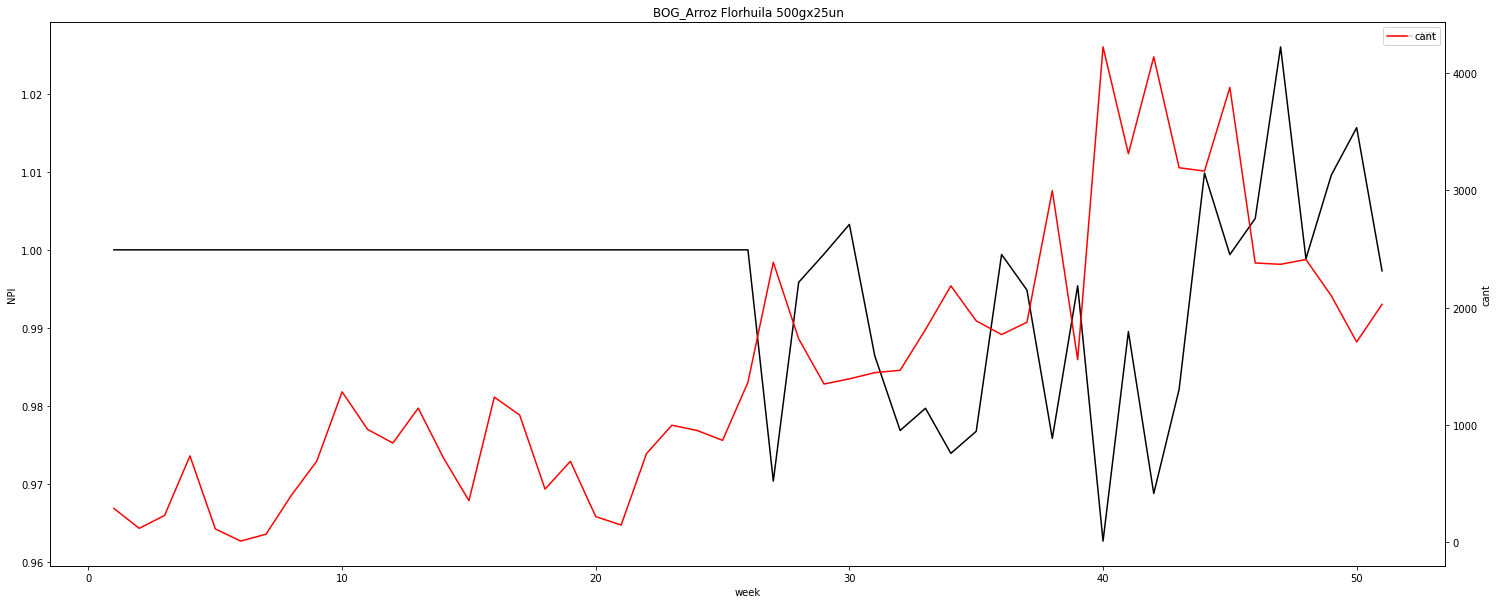

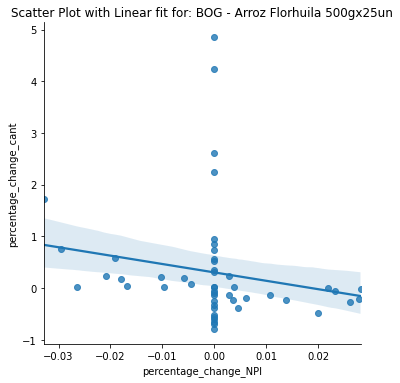

In [75]:
graphic_time(-200658)

In [58]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [76]:
beef_model = ols("cant_total ~ NPI", data=df_aux[df_aux.padre_sku_id == -200658]).fit()
print(beef_model.summary())

                            OLS Regression Results                            
Dep. Variable:             cant_total   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     12.27
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           0.000994
Time:                        15:54:49   Log-Likelihood:                -422.31
No. Observations:                  51   AIC:                             848.6
Df Residuals:                      49   BIC:                             852.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.224e+04   1.16e+04      3.631      0.0

eval_env: 1
eval_env: 1


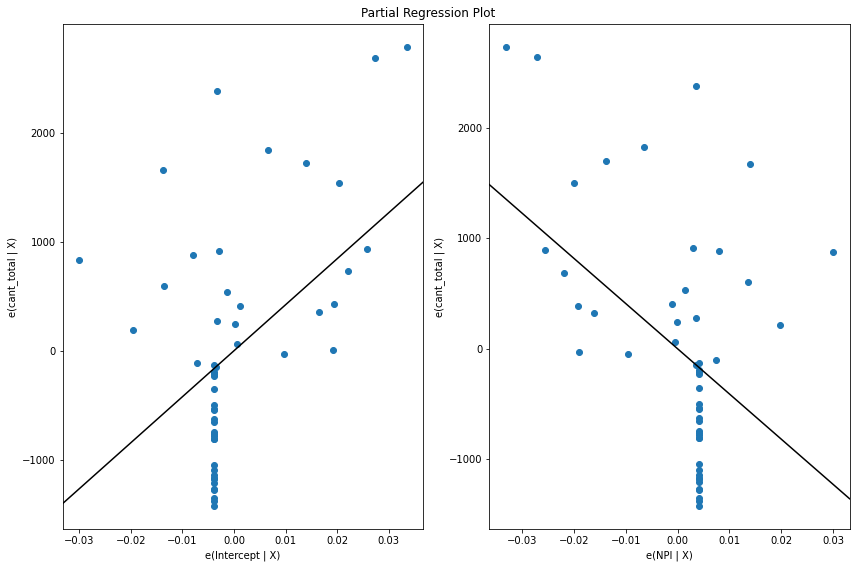

In [77]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(beef_model, fig=fig)

In [68]:
#Make sure to not have any duplicates in the data
df_aux_2 = df_aux[(df_aux.city == 'BOG') & (df_aux.cat == 'Abarrotes')].groupby(['week','name']).agg({'NPI':'mean','cant_total': 'mean' }).reset_index()

#laptop data used for price elasticities
df_aux_2.head()

,week,name,NPI,cant_total
0,1,Aceite Naoli 3LT,1.020095,1218.0
1,1,Aceite Riquísimo 1LT,1.000000,11.0
2,1,Aceite Sólido Bucaro x 15kg,1.000000,259.0
3,1,Aceite Vivi 20LT,1.133445,31.0
4,1,Aceite Vivi 5LT,1.000000,102.0


In [69]:
#Format and build a dataframe with x_values for each product within the caregory
x_pivot = df_aux_2.pivot(index= 'week' ,columns='name' ,values='NPI')
x_values = pd.DataFrame(x_pivot.to_records())
x_values.head(3)

,week,Aceite Naoli 20LT,Aceite Naoli 20LT (Sin IVA),Aceite Naoli 3LT,Aceite Oleosuper x 20 Lts (SIN IVA),Aceite Riquísimo 1LT,Aceite Sólido Bucaro x 15kg,Aceite Sólido Bucaro x 15kg (Sin IVA),Aceite Vivi 20LT,Aceite Vivi 5LT,...,Margarina Duquesa Pan Bloque x 15kg,Margarina Duquesa Pan Bloque x 15kg (Sin IVA),Margarina La Preferida x 500gr,Margarina Rico Hojaldre Caja x 30 Unid de 500gr,Maíz Pira Sudespensa x 500g,Panela En polvo x 400gr,Panela Pulverizada Saborizada Con Limón x1000gr,Panela Pulverizada Saborizada Con Limón x400gr,Panela Pulverizada Saborizada Con Limón x5kg,Panela en pastillas 500gr
0,1,NaN,NaN,1.020095,NaN,1.0,1.0,NaN,1.133445,1.0,...,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0
1,2,NaN,NaN,1.015868,NaN,NaN,1.0,NaN,1.126117,1.0,...,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0
2,3,NaN,NaN,1.003127,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0


In [70]:
#Format and build a dataframe with y_values for each product within the caregory
y_pivot = df_aux_2.pivot( index = 'week',columns='name', values='cant_total')
y_values = pd.DataFrame(y_pivot.to_records())
y_values.head(3)

,week,Aceite Naoli 20LT,Aceite Naoli 20LT (Sin IVA),Aceite Naoli 3LT,Aceite Oleosuper x 20 Lts (SIN IVA),Aceite Riquísimo 1LT,Aceite Sólido Bucaro x 15kg,Aceite Sólido Bucaro x 15kg (Sin IVA),Aceite Vivi 20LT,Aceite Vivi 5LT,...,Margarina Duquesa Pan Bloque x 15kg,Margarina Duquesa Pan Bloque x 15kg (Sin IVA),Margarina La Preferida x 500gr,Margarina Rico Hojaldre Caja x 30 Unid de 500gr,Maíz Pira Sudespensa x 500g,Panela En polvo x 400gr,Panela Pulverizada Saborizada Con Limón x1000gr,Panela Pulverizada Saborizada Con Limón x400gr,Panela Pulverizada Saborizada Con Limón x5kg,Panela en pastillas 500gr
0,1,NaN,NaN,1218.00,NaN,11.0,259.0,NaN,31.0,102.0,...,81.0,NaN,NaN,10.00,16.0,NaN,NaN,NaN,NaN,920.9
1,2,NaN,NaN,1438.94,NaN,NaN,275.0,NaN,1.0,129.0,...,104.0,NaN,NaN,17.74,38.0,NaN,NaN,NaN,NaN,1400.0
2,3,NaN,NaN,2332.00,NaN,NaN,296.0,NaN,NaN,119.0,...,54.0,NaN,NaN,19.00,44.0,NaN,NaN,NaN,NaN,1832.0


In [71]:
points = []
results_values = {
    "name": [],
    "price_elasticity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "t_score":[],
    "slope": [],
    "coefficient_pvalue" : [],
}
#Append x_values with y_values per same product name
for column in x_values.columns[1:]:
    column_points = []
    for i in range(len(x_values[column])):
        if not np.isnan(x_values[column][i]) and not np.isnan(y_values[column][i]):
            column_points.append((x_values[column][i], y_values[column][i]))
    df = pd.DataFrame(list(column_points), columns= ['x_value', 'y_value'])


    #Linear Regression Model
    import statsmodels.api as sm
    x_value = df['x_value']
    y_value = df['y_value']
    X = sm.add_constant(x_value)
    model = sm.OLS(y_value, X)
    result = model.fit()
    
    
    #(Null Hypothesis test) Coefficient with a p value less than 0.05
    if result.f_pvalue < 0.05:
        
        rsquared = result.rsquared
        coefficient_pvalue = result.f_pvalue
        intercept, slope = result.params
        mean_price = np.mean(x_value)
        mean_quantity = np.mean(y_value)
        tintercept, t_score = result.tvalues
     
        #Price elasticity Formula
        price_elasticity = (slope)*(mean_price/mean_quantity)    
            
        #Append results into dictionary for dataframe
        results_values["name"].append(column)
        results_values["price_elasticity"].append(price_elasticity)
        results_values["price_mean"].append(mean_price)
        results_values["quantity_mean"].append(mean_quantity)
        results_values["intercept"].append(intercept)
        results_values['t_score'].append(t_score)
        results_values["slope"].append(slope)
        results_values["coefficient_pvalue"].append(coefficient_pvalue)
        
final_df = pd.DataFrame.from_dict(results_values)
df_elasticity = final_df[['name','price_elasticity','t_score','coefficient_pvalue','slope','price_mean','quantity_mean','intercept']]

In [72]:
df_elasticity

,name,price_elasticity,t_score,coefficient_pvalue,slope,price_mean,quantity_mean,intercept
0,Aceite Naoli 20LT,-4.382467,-2.709718,1.004643e-02,-2669.881896,0.945193,575.829750,3099.384600
1,Aceite Naoli 3LT,-6.207697,-5.923514,3.069271e-07,-25451.421644,0.959001,3931.884510,28339.831644
2,Aceite Sólido Bucaro x 15kg,-3.022341,-2.126911,3.848735e-02,-564.921062,1.016400,189.980392,764.165962
3,Aceite sólido Naoli 15kg,-8.282530,-4.168125,2.418342e-03,-1114.385114,1.016276,136.736364,1269.259336
4,Arroz Florhuila 500gx25un,-27.238726,-3.502489,9.938883e-04,-40907.395349,0.995923,1495.686863,42236.292204
5,Arroz Naoli 500gx25un,-3.885737,-2.610515,1.196099e-02,-8932.218028,0.956581,2198.912157,10743.305970
6,Azúcar Bulto 50kg,-8.361260,-4.558723,3.674626e-05,-18598.295749,1.012857,2252.940408,21090.360856
7,Frijol Bola Roja Naoli de 500gr,-4.510210,-8.057437,2.843968e-10,-10922.338976,1.017421,2463.880851,13576.500493
8,Garbanzo Naoli de 500gr,-1.364702,-2.476407,1.692771e-02,-2125.713078,0.927682,1444.994490,3416.981109
9,Harina de Trigo Elite Hojaldre 3 Castillos x 50kg,3.547133,2.751264,8.587383e-03,135.905947,1.004824,38.499130,-98.062391


In [146]:
y=3099.384600-2669.881896*1.0397123 # quantity_sold = intercept + slope*price_index_mean
y

323.4755531814794

In [143]:
0.945193*1.1

1.0397123

In [147]:
575.8309210740722*(1+(-4.382467/10))

323.4749201553996

In [90]:
def divergent_plot(df, values_column, ylabel, xlabel):

    #Divergent plot
    df['ranking'] = df[values_column].rank( ascending = True).astype(int)
    df.sort_values(values_column, ascending =False, inplace = True)
    plt.figure(figsize = (12,5), dpi = 80)
    plt.hlines(y = df['ranking'] , xmin = 0, xmax = df[values_column], alpha = 0.5, linewidth = 3)
    
    #Add elasticity labels
    for x, y, tex in zip(df[values_column], df['ranking'] , df[values_column]):
        plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':10})
        
    
    # Axis and title
    plt.gca().set(ylabel= ylabel, xlabel= xlabel)
    plt.yticks(df['ranking'])
    plt.title(values_column , fontdict={'size':13})
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()
            
    
    #Adjust Ranking column and print dataframe
    pd.set_option('display.width', 4000)
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    
    df = df.iloc[:,:3]
    df.set_index('ranking', inplace=True)
    display(df)
    return df

/home/jupyter-felipe.guevara/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/tljh/user/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


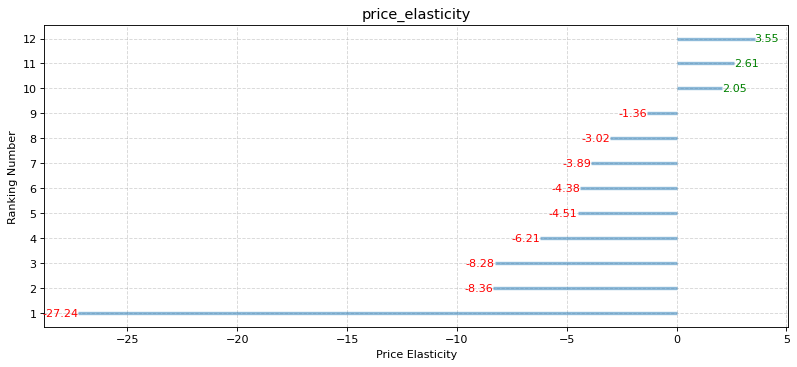

,name,price_elasticity
ranking,,
12,Harina de Trigo Elite Hojaldre 3 Castillos x 50kg,3.547133
11,Margarina Astor Aliñado x 15 Kg,2.609616
10,Panela en pastillas 500gr,2.050982
9,Garbanzo Naoli de 500gr,-1.364702
8,Aceite Sólido Bucaro x 15kg,-3.022341
7,Arroz Naoli 500gx25un,-3.885737
6,Aceite Naoli 20LT,-4.382467
5,Frijol Bola Roja Naoli de 500gr,-4.510210
4,Aceite Naoli 3LT,-6.207697


In [91]:
pe_plot = divergent_plot(df_elasticity, 'price_elasticity', 'Ranking Number', 'Price Elasticity')

In [93]:
pe_plot

,name,price_elasticity
ranking,,
12,Harina de Trigo Elite Hojaldre 3 Castillos x 50kg,3.547133
11,Margarina Astor Aliñado x 15 Kg,2.609616
10,Panela en pastillas 500gr,2.050982
9,Garbanzo Naoli de 500gr,-1.364702
8,Aceite Sólido Bucaro x 15kg,-3.022341
7,Arroz Naoli 500gx25un,-3.885737
6,Aceite Naoli 20LT,-4.382467
5,Frijol Bola Roja Naoli de 500gr,-4.510210
4,Aceite Naoli 3LT,-6.207697
